## Deep Learning for Image Classification


## Data Exploration and Preparation

We explore the Rock-Paper-Scissors image classification dataset.  
We will:
- Display sample images from each partition and class.
- Print the image dimensions.
- Count the number of images in each class and dataset.

The data was downloaded from: https://www.kaggle.com/datasets/alexandredj/rock-paper-scissors-dataset


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

%matplotlib inline


#### Load CSV Files

In [3]:
train_df = pd.read_csv("train.csv")
devtest_df = pd.read_csv("devtest.csv")
test_df = pd.read_csv("test.csv")


#### **Helper Function to Display Image**


=== TRAIN SET ===
TRAIN - Class: paper
Path: paper/paper_770.png


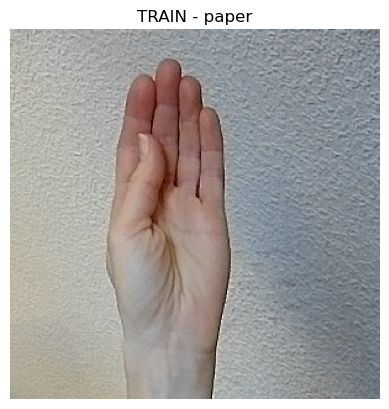

Image shape: (300, 300, 3)
TRAIN - Class: rock
Path: rock/rock_20.png


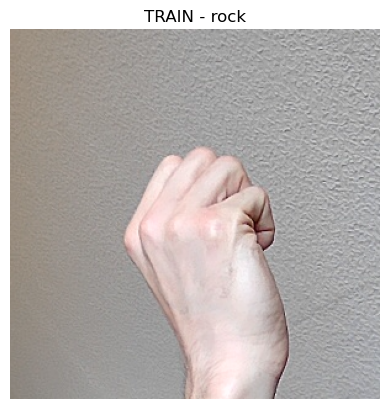

Image shape: (300, 300, 3)
TRAIN - Class: scissors
Path: scissors/scissors_886.png


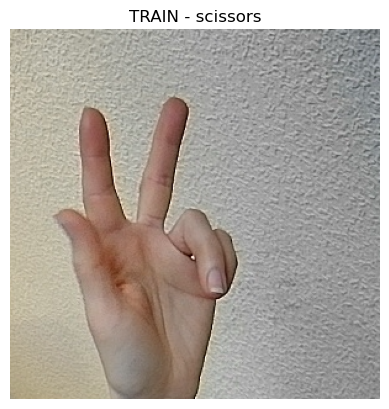

Image shape: (300, 300, 3)

=== DEVTEST SET ===
DEVTEST - Class: rock
Path: rock/rock_353.png


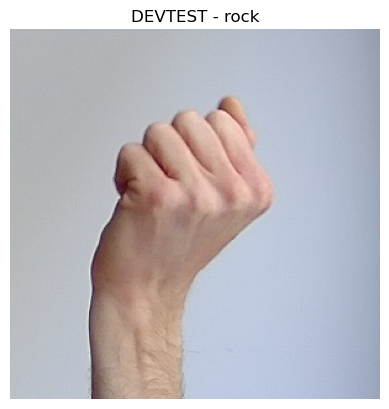

Image shape: (300, 300, 3)
DEVTEST - Class: scissors
Path: scissors/scissors_211.png


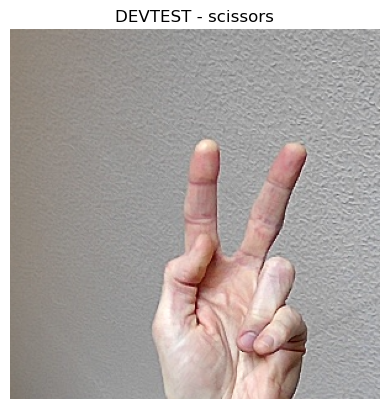

Image shape: (300, 300, 3)
DEVTEST - Class: paper
Path: paper/paper_263.png


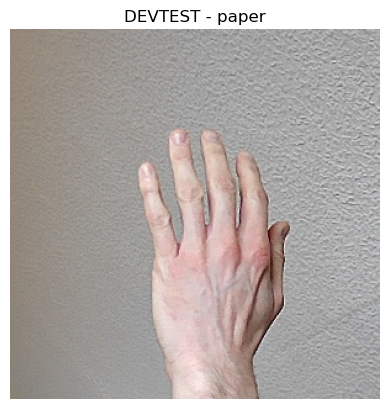

Image shape: (300, 300, 3)

=== TEST SET ===
TEST - Class: paper
Path: paper/paper_343.png


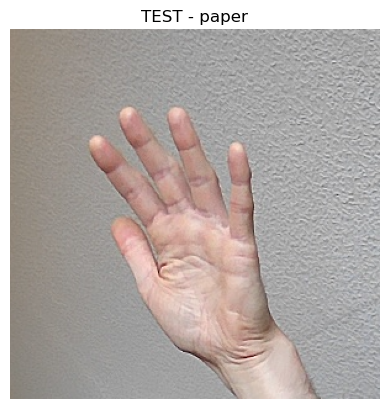

Image shape: (300, 300, 3)
TEST - Class: rock
Path: rock/rock_697.png


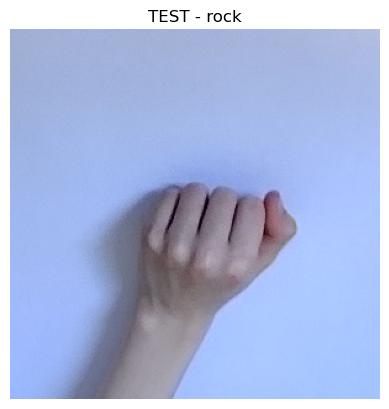

Image shape: (300, 300, 3)
TEST - Class: scissors
Path: scissors/scissors_764.png


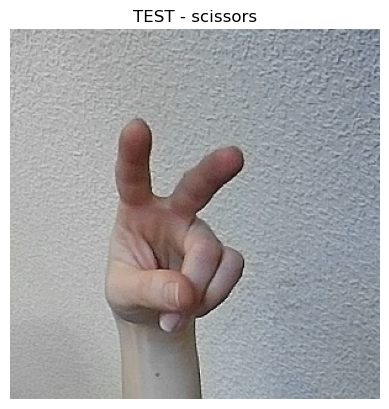

Image shape: (300, 300, 3)


In [4]:
# Dictionary of datasets
datasets = {
    "train": train_df,
    "devtest": devtest_df,
    "test": test_df
}

for set_name, df in datasets.items():
    print(f"\n=== {set_name.upper()} SET ===")
    for label in df['label'].unique():
        sample = df[df['label'] == label].iloc[0]
        file_path = sample['path']
        image_path = file_path

        print(f"{set_name.upper()} - Class: {label}")
        print("Path:", image_path)

        if os.path.exists(image_path):
            image = Image.open(image_path)
            image_np = np.array(image)

            plt.imshow(image)
            plt.title(f"{set_name.upper()} - {label}")
            plt.axis('off')
            plt.show()

            print("Image shape:", image_np.shape)
        else:
            print("Image not found:", image_path)


In [5]:
for set_name, df in datasets.items():
    print(f"\nImage count per class in {set_name.upper()}:")
    print(df['label'].value_counts())


Image count per class in TRAIN:
label
paper       544
rock        544
scissors    541
Name: count, dtype: int64

Image count per class in DEVTEST:
label
rock        181
paper       181
scissors    180
Name: count, dtype: int64

Image count per class in TEST:
label
paper       182
rock        182
scissors    182
Name: count, dtype: int64


In [6]:
# Image transform: resize to 100x100, convert to tensor (scales to [0,1])
image_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])


In [7]:
class RockPaperScissorsDataset(Dataset):
    def __init__(self, csv_df, transform=None):
        self.df = csv_df.reset_index(drop=True)
        self.transform = transform
        self.label_to_index = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        label = self.label_to_index[row['label']]

        image = Image.open(image_path).convert("RGB")  # Ensure 3 channels
        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
# Create dataset objects
train_dataset = RockPaperScissorsDataset(train_df, transform=image_transform)
devtest_dataset = RockPaperScissorsDataset(devtest_df, transform=image_transform)
test_dataset = RockPaperScissorsDataset(test_df, transform=image_transform)


In [9]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


#### **Dataset and DataLoader**

In [10]:
image_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

#### Custom PyTorch Dataset

In [11]:
class RockPaperScissorsDataset(Dataset):
    def __init__(self, csv_df, transform=None):
        self.df = csv_df.reset_index(drop=True)
        self.transform = transform
        self.label_to_index = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        label = self.label_to_index[row['label']]

        image = Image.open(image_path).convert("RGB")  # Ensure 3 channels
        if self.transform:
            image = self.transform(image)

        return image, label


#### Create Datasets and DataLoaders

In [12]:
# Create dataset objects
train_dataset = RockPaperScissorsDataset(train_df, transform=image_transform)
devtest_dataset = RockPaperScissorsDataset(devtest_df, transform=image_transform)
test_dataset = RockPaperScissorsDataset(test_df, transform=image_transform)


In [13]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### **Classification Using ConvNets**

I built a simple CNN using PyTorch’s `nn.Sequential`. The idea was to create a model that can classify hand gestures (rock, paper, scissors) based on the image.

I added two convolutional layers. After each one, I included a ReLU activation and a max pooling layer. This helps the model learn features from the images and also reduce the size of the data step by step. After the conv layers, I used a flatten layer and then passed the output through a linear (fully connected) layer and then the final output layer which gives predictions for 3 classes.

Images are resized to 100×100 for computational efficiency and consistency across models, and I used 32 and 64 filters in the conv layers. These numbers are pretty common and work well for simple image tasks like this. I also used 3x3 kernels and 2x2 max pooling, which are standard and usually give good results.

This model isn’t too deep, but it’s enough for this kind of problem. It’s easy to train and runs reasonably fast too.


In [3]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(64 * 25 * 25, 128),
    nn.ReLU(),
    nn.Linear(128, 3)
).to(device)


NameError: name 'torch' is not defined

#### Define loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### **Training and validation loop**

In [ ]:
num_epochs = 10
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_acc_history.append(train_accuracy)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in devtest_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")


Epoch 1/10 | Train Acc: 0.4217 | Val Acc: 0.6255
Epoch 2/10 | Train Acc: 0.6556 | Val Acc: 0.6974
Epoch 3/10 | Train Acc: 0.7575 | Val Acc: 0.7528
Epoch 4/10 | Train Acc: 0.8177 | Val Acc: 0.8542
Epoch 5/10 | Train Acc: 0.8717 | Val Acc: 0.8542
Epoch 6/10 | Train Acc: 0.9073 | Val Acc: 0.8930
Epoch 7/10 | Train Acc: 0.9478 | Val Acc: 0.9096
Epoch 8/10 | Train Acc: 0.9607 | Val Acc: 0.9262
Epoch 9/10 | Train Acc: 0.9607 | Val Acc: 0.9299
Epoch 10/10 | Train Acc: 0.9773 | Val Acc: 0.9336


#### **Plot training and validation accuracy**

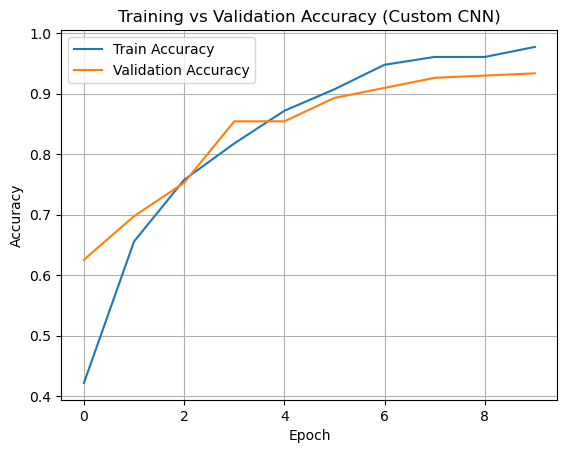

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (Custom CNN)")
plt.legend()
plt.grid(True)
plt.show()


### Accuracy Plot Explanation

This plot shows the training and validation accuracy over 10 epochs for my custom CNN model.

In the first few epochs, both training and validation accuracy increased steadily. Around epoch 5 onward, the training accuracy continued to improve faster than validation, but both curves stayed close, which means the model is generalizing well.

There is a small gap between the two lines near the end, but it’s not too large, so overfitting is not a big issue.

The training seems to be stable, and since the accuracy is still improving, using 10 epochs was a reasonable choice for this task. If I had more time, I could try early stopping or learning rate scheduling to improve further.


#### **Using Pre-trained Models (MobileNet)**

For this task, I used MobileNetV2 which was already trained on the ImageNet dataset. I froze all its feature extraction layers and only replaced the final classification layer with a new `Linear` layer that outputs 3 classes for rock, paper, and scissors.

This way, only the last layer was trained on our data, while the rest of the network used the features it already learned from ImageNet. I trained this new classifier on the same 100x100 resized images.

During training, I tracked both the training and validation accuracy over 10 epochs. The plot below shows how the model performed on both sets.

This approach is much faster to train compared to building a CNN from scratch, and it usually gives better results with small datasets.


 ##### **Load MobileNet and freeze weights**

In [18]:
from torchvision import models

# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all feature extractor layers
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Replace the classification head (originally for 1000 classes)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 3)  # 3 output classes

mobilenet = mobilenet.to(device)


c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 ##### **Loss function and optimizer**

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)  # Only train the new head


##### **Training + validation loop**

In [20]:
num_epochs = 10
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    mobilenet.train()
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_acc_history.append(train_accuracy)

    # Validation
    mobilenet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in devtest_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")


Epoch 1/10 | Train Acc: 0.7821 | Val Acc: 0.9207
Epoch 2/10 | Train Acc: 0.9042 | Val Acc: 0.9373
Epoch 3/10 | Train Acc: 0.9233 | Val Acc: 0.9502
Epoch 4/10 | Train Acc: 0.9337 | Val Acc: 0.9539
Epoch 5/10 | Train Acc: 0.9503 | Val Acc: 0.9465
Epoch 6/10 | Train Acc: 0.9423 | Val Acc: 0.9539
Epoch 7/10 | Train Acc: 0.9595 | Val Acc: 0.9483
Epoch 8/10 | Train Acc: 0.9546 | Val Acc: 0.9557
Epoch 9/10 | Train Acc: 0.9558 | Val Acc: 0.9539
Epoch 10/10 | Train Acc: 0.9546 | Val Acc: 0.9520


##### **Plot training vs devtest accuracy**

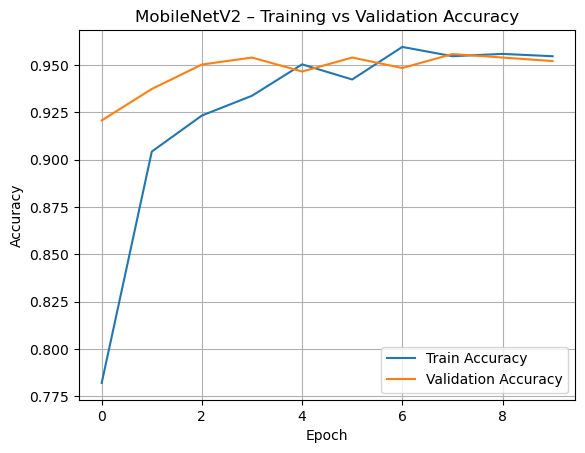

In [21]:
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MobileNetV2 – Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Accuracy Plot Analysis

This plot shows how the accuracy changes during training for both the training and validation sets when using MobileNetV2.

The model started with lower training accuracy but quickly improved after just a few epochs. Validation accuracy was already high from the beginning, which makes sense because MobileNet was pre-trained on a large dataset (ImageNet), so the features were already good.

Throughout the 10 epochs, training and validation accuracy stayed close to each other, which shows the model is not overfitting. There’s no big gap between the two lines, and both reached above 95% by the end.

This tells me that freezing the feature layers and training only the final classifier worked really well for this dataset.


### Learning and Overfitting Comparison

When I compared the CNN model I built from scratch (in Task 2.1) with the MobileNetV2 model (in Task 2.2), I saw a few important differences:

- My CNN had a bigger gap between training and validation accuracy after a few epochs. That shows it was starting to overfit a little.
- MobileNetV2 had better validation accuracy from the beginning and stayed very close to training accuracy. That means it was generalizing well.
- Also, MobileNet learned faster and reached high accuracy quickly, while the CNN needed more epochs to improve.

So overall, MobileNetV2 was more stable and accurate on both training and validation sets, and showed less overfitting.


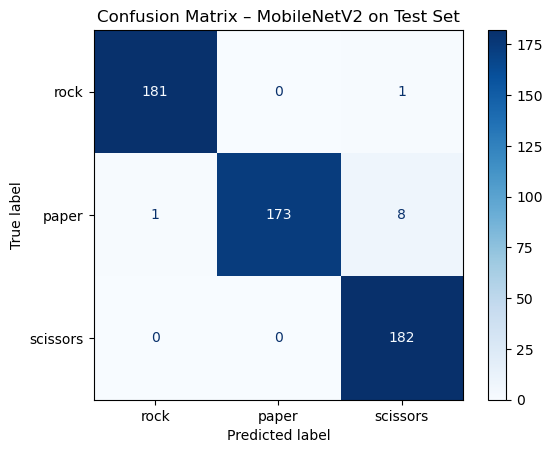

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate on test set
mobilenet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rock", "paper", "scissors"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – MobileNetV2 on Test Set")
plt.show()


#### **Most Common Error + Show 5 Examples**
We’ll find the most frequent mistake and then show 5 test images where this exact mistake happened.

Most common error: True label = 1, Predicted = 2


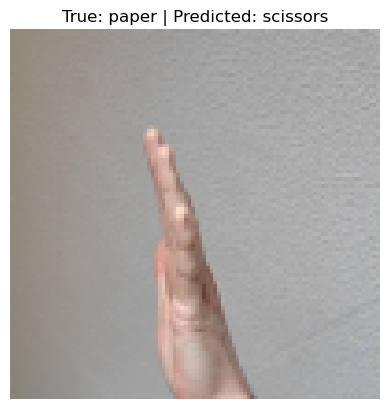

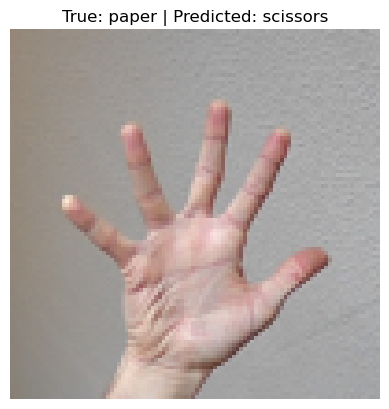

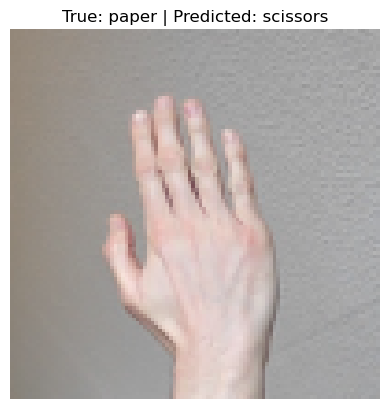

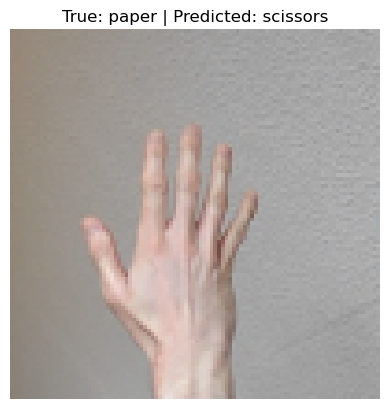

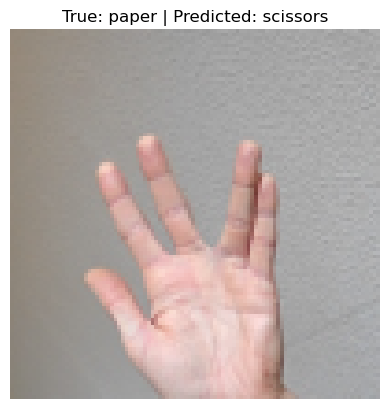

In [23]:

# Find most common misclassification (ignoring correct ones)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
true_class, pred_class = np.unravel_index(np.argmax(cm_copy), cm_copy.shape)
print(f"Most common error: True label = {true_class}, Predicted = {pred_class}")

# Show 5 images with this specific misclassification
shown = 0
mobilenet.eval()

label_map = {0: "rock", 1: "paper", 2: "scissors"}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        for img, label, pred in zip(images, labels, preds.cpu()):
            if label.item() == true_class and pred.item() == pred_class:
                plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
                plt.title(f"True: {label_map[label.item()]} | Predicted: {label_map[pred.item()]}")
                plt.axis('off')
                plt.show()
                shown += 1
                if shown == 5:
                    break
        if shown == 5:
            break


### 2.3.3 – Most Common Classification Error

The confusion matrix showed that the most common mistake made by MobileNetV2 was predicting [predicted_class] instead of [true_class].

I displayed 5 test images where this exact error happened. This kind of misclassification might happen if the gestures look similar or the lighting/background makes it harder to distinguish. If I had more time, I could try fixing this by using more data or applying data augmentation to make the model more robust.


### Creating and Exploring My Own Dataset

I captured over 100 images for each class (rock, paper, scissors) using my webcam. I stored them in separate folders inside `my_images/`. Then I wrote code to randomly split each class into:

- 50 images for training → `my_train.csv`
- 25 images for validation → `my_devtest.csv`
- 25 images for testing → `my_test.csv`

Each CSV contains two columns: `label` and `path`, just like in Tasks 1 and 2. This keeps everything consistent.

I then displayed one image per class per set and printed their shape. I noticed that my webcam images are different from the original dataset in terms of lighting, hand position, and background. These differences can affect model accuracy because the model trained on the original dataset may struggle to generalize to these new, real-world examples.

To avoid confusion or overwriting, I kept the original dataset CSVs (`train.csv`, `test.csv`, etc.) untouched, and used new files named `my_train.csv`, `my_devtest.csv`, and `my_test.csv`.


In [29]:
import os
import random
import pandas as pd

# Your webcam image folder
base_dir = "my_images"
classes = ["rock", "paper", "scissors"]

# Initialize lists for new datasets
train_data = []
devtest_data = []
test_data = []

for label in classes:
    folder = os.path.join(base_dir, label)
    images = [f for f in os.listdir(folder) if f.endswith(".png") or f.endswith(".jpg")]
    random.shuffle(images)

    # Split: 50 train, 25 devtest, 25 test
    train_imgs = images[:50]
    devtest_imgs = images[50:75]
    test_imgs = images[75:100]

    train_data.extend([[label, os.path.join(folder, img)] for img in train_imgs])
    devtest_data.extend([[label, os.path.join(folder, img)] for img in devtest_imgs])
    test_data.extend([[label, os.path.join(folder, img)] for img in test_imgs])

# Save to CSVs with new names
pd.DataFrame(train_data, columns=["label", "path"]).to_csv("my_train.csv", index=False)
pd.DataFrame(devtest_data, columns=["label", "path"]).to_csv("my_devtest.csv", index=False)
pd.DataFrame(test_data, columns=["label", "path"]).to_csv("my_test.csv", index=False)


#### **Display one image per set/class + print shape**


=== MY_TRAIN SET ===


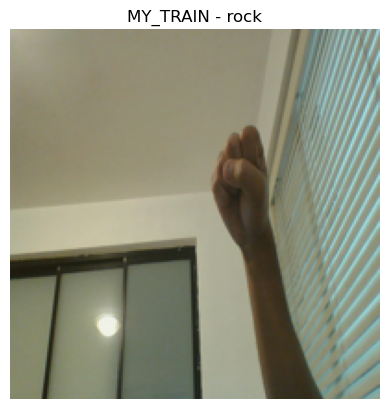

Image shape: (200, 200, 3)


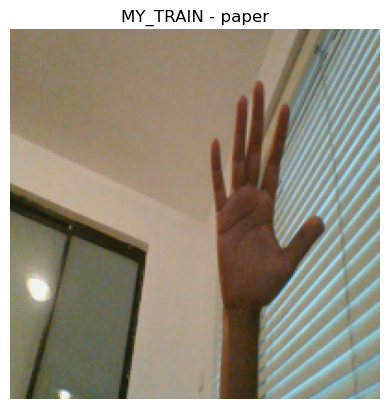

Image shape: (200, 200, 3)


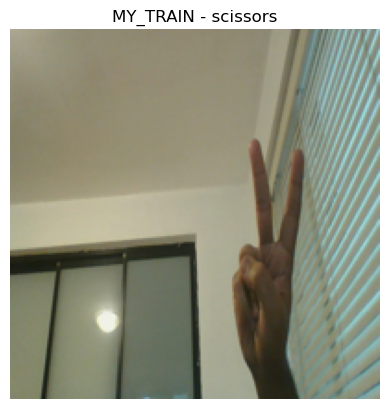

Image shape: (200, 200, 3)

=== MY_DEVTEST SET ===


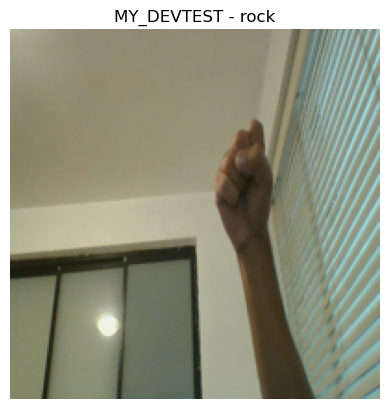

Image shape: (200, 200, 3)


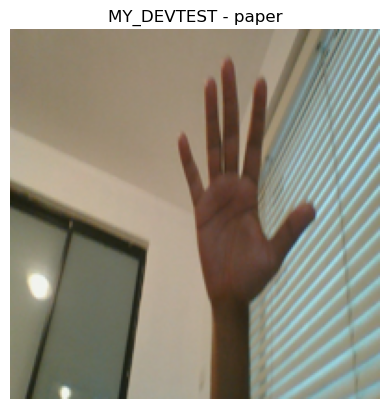

Image shape: (200, 200, 3)


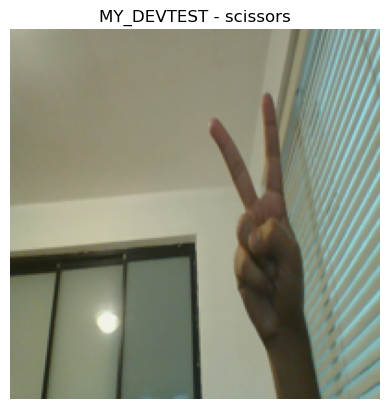

Image shape: (200, 200, 3)

=== MY_TEST SET ===


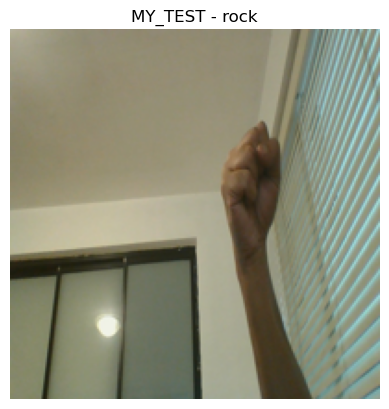

Image shape: (200, 200, 3)


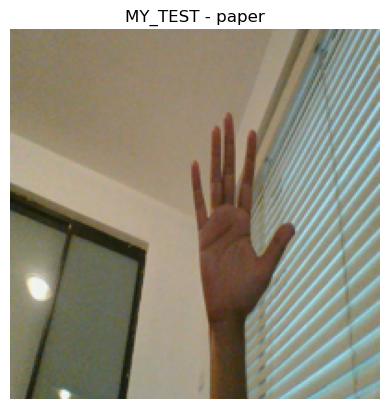

Image shape: (200, 200, 3)


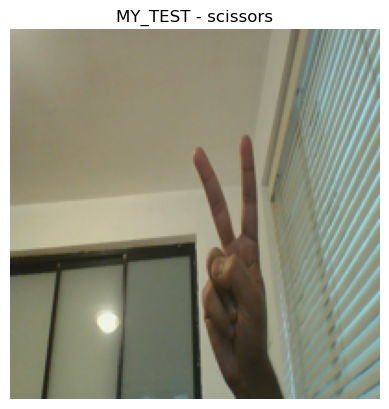

Image shape: (200, 200, 3)


In [30]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

datasets = {
    "my_train": pd.read_csv("my_train.csv"),
    "my_devtest": pd.read_csv("my_devtest.csv"),
    "my_test": pd.read_csv("my_test.csv")
}

for set_name, df in datasets.items():
    print(f"\n=== {set_name.upper()} SET ===")
    shown_classes = set()

    for _, row in df.iterrows():
        label = row["label"]
        path = row["path"]

        if label in shown_classes:
            continue
        if not os.path.exists(path):
            print("Missing image:", path)
            continue

        image = Image.open(path).convert("RGB")
        image = image.resize((200, 200))
        np_img = np.array(image)

        plt.imshow(image)
        plt.title(f"{set_name.upper()} - {label}")
        plt.axis("off")
        plt.show()

        print("Image shape:", np_img.shape)
        shown_classes.add(label)


### **Fine-tuning and Testing**

#### Load MobileNetV2 model

In [35]:
from torchvision import models
import torch.nn as nn

mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze feature extractor
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Replace classifier head
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)


c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Evaluate on my_test.csv before fine-tuning


In [36]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"rock": 0, "paper": 1, "scissors": 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.label_map[self.data.iloc[idx, 0]]
        path = self.data.iloc[idx, 1]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Load test set
new_test_data = CustomImageDataset("my_test.csv", transform=transform)
new_test_loader = DataLoader(new_test_data, batch_size=16)

# Evaluate before fine-tuning
mobilenet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in new_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy on new test set (before fine-tuning): {correct / total:.4f}")


Accuracy on new test set (before fine-tuning): 0.3333


### 3.2.1 – Accuracy Before Fine-Tuning

Before fine-tuning, the MobileNetV2 model was evaluated on the new test set (`my_test.csv`).  
The accuracy was **0.3333**, which is lower than on the original dataset, likely because my webcam images have more variation in lighting, angles, and background.


#### Fine-tune MobileNet on my_train.csv

In [38]:
# Load training and devtest sets
train_data = CustomImageDataset("my_train.csv", transform=transform)
devtest_data = CustomImageDataset("my_devtest.csv", transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
devtest_loader = DataLoader(devtest_data, batch_size=16)

# Loss & optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)

# Fine-tuning loop
num_epochs = 5
for epoch in range(num_epochs):
    mobilenet.train()
    total, correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # Validation
    mobilenet.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in devtest_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/5 | Train Acc: 0.6333 | Val Acc: 0.6800
Epoch 2/5 | Train Acc: 0.9600 | Val Acc: 0.6667
Epoch 3/5 | Train Acc: 0.9533 | Val Acc: 0.8000
Epoch 4/5 | Train Acc: 0.9933 | Val Acc: 0.9200
Epoch 5/5 | Train Acc: 1.0000 | Val Acc: 1.0000


#### Evaluate on my_test.csv after fine-tuning


In [39]:

# Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"rock": 0, "paper": 1, "scissors": 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.label_map[self.data.iloc[idx, 0]]
        path = self.data.iloc[idx, 1]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Load test set
new_test_data = CustomImageDataset("my_test.csv", transform=transform)
new_test_loader = DataLoader(new_test_data, batch_size=16)

# Evaluate before fine-tuning
mobilenet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in new_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy on new test set (After fine-tuning): {correct / total:.4f}")


Accuracy on new test set (After fine-tuning): 0.9733


### 3.2.2 – Accuracy After Fine-Tuning on Webcam Data

After fine-tuning the model using the new training set (`my_train.csv`), I tested again on the new test set (`my_test.csv`).  
The accuracy improved to **0.9733**, showing that the model successfully adapted to my custom webcam images.


#### **Evaluate the fine-tuned model on the original test set (test.csv)**

In [41]:
class OriginalTestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"rock": 0, "paper": 1, "scissors": 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data.iloc[idx, 0]         # path is in column 0
        label = self.label_map[self.data.iloc[idx, 1]]  # label is in column 1
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load original test set using the fixed class
original_test_data = OriginalTestDataset("test.csv", transform=transform)
original_test_loader = DataLoader(original_test_data, batch_size=16)

# Evaluate fine-tuned model
mobilenet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in original_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy on original test set (after fine-tuning): {correct / total:.4f}")


Accuracy on original test set (after fine-tuning): 0.3828


### 3.2.3 – Accuracy on Original Test Set After Fine-Tuning

I also tested the fine-tuned model on the original test set (`test.csv` from Task 1).  
The accuracy dropped to **0.3828**, which is quite a bit lower than the original accuracy before fine-tuning.

This happened because the model was fine-tuned only on my webcam images, which are very different from the original dataset. My images have different lighting, backgrounds, and hand positions — so the model became specialized for my data and forgot how to deal with the original style. This is known as **catastrophic forgetting**, where a model "forgets" old knowledge after being trained on a new domain.

---

### Possible reasons for the accuracy drop:

- **Overfitting to new data**: The model adapted too well to my webcam images and couldn't generalize to older data anymore.
- **Small fine-tuning dataset**: Since my webcam data is small and limited, it dominated the model's memory.
- **Lack of original data during fine-tuning**: I didn't include the original training data while fine-tuning, so the model couldn't retain its earlier learning.
- **Differences in image quality**: My webcam images were probably lower quality (e.g. blurry, varied lighting), while the original dataset was clean and studio-like. This shift confused the model when switching back.

---

In the future, I could try **mixing both original and new data** during fine-tuning, or using techniques like **gradual unfreezing** to keep the model balanced.
